In [1]:
%matplotlib inline


# Visualizing the stock market structure


This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.

.. _stock_market:

Learning a graph structure
--------------------------

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of connection. For each
symbol, the symbols that it is connected too are those useful to explain
its fluctuations.

Clustering
----------

We use clustering to group together quotes that behave similarly. Here,
amongst the :ref:`various clustering techniques <clustering>` available
in the scikit-learn, we use :ref:`affinity_propagation` as it does
not enforce equal-size clusters, and it can choose automatically the
number of clusters from the data.

Note that this gives us a different indication than the graph, as the
graph reflects conditional relations between variables, while the
clustering reflects marginal properties: variables clustered together can
be considered as having a similar impact at the level of the full stock
market.

Embedding in 2D space
---------------------

For visualization purposes, we need to lay out the different symbols on a
2D canvas. For this we use :ref:`manifold` techniques to retrieve 2D
embedding.


Visualization
-------------

The output of the 3 models are combined in a 2D graph where nodes
represents the stocks and edges the:

- cluster labels are used to define the color of the nodes
- the sparse covariance model is used to display the strength of the edges
- the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as
visualization is crucial here to display the graph. One of the challenge
is to position the labels minimizing overlap. For this we use an
heuristic based on the direction of the nearest neighbor along each
axis.


In [136]:
print(__doc__)

# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import datetime

import numpy as np
import matplotlib.pyplot as plt
try:
     from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
     # quotes_historical_yahoo_ochl was named quotes_historical_yahoo before matplotlib 1.4
     from matplotlib.finance import quotes_historical_yahoo as quotes_historical_yahoo_ochl
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

Automatically created module for IPython interactive environment


Retrieve the data from Internet


In [137]:
# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash), you can also choose other time window
d1 = datetime.datetime(2003, 1, 1)
d2 = datetime.datetime(2008, 1, 1)

# kraft symbol has now changed from KFT to MDLZ in yahoo
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T



quotes = [quotes_historical_yahoo_ochl(symbol, d1, d2, asobject=True)
          for symbol in symbols]


open_0=quotes[0].open

open = np.array([q.open for q in quotes]).astype(np.float)
close = np.array([q.close for q in quotes]).astype(np.float)

# The daily variations of the quotes are what carry most information
variation = close - open

print variation.shape


(60, 1258)


In [138]:
import pandas as pd 

# We pick the example of TOT with index 0
df = pd.DataFrame(quotes[0])

# df.to_csv("file_path.csv")

# We create a target column, the difference between the open price in 
# the second business day and the adjusted close price of the current day  
df['future_diff'] = df.open.shift(-1) - df.aclose
df = df[:-1]

predict_down = df['future_diff']<=-0.005
predict_rise = df['future_diff']>=0.005
predict_flat = np.logical_and(df['future_diff']>-0.005, df['future_diff']<0.005)

#predict_flat = predict_negative_zero and predict_positive_zero

#help(predict_positive_zero)
df['target'] = ''

df.loc[predict_down, 'target']='DOWN'
df.loc[predict_rise, 'target']='UP'
df.loc[predict_flat, 'target']='FLAT'

del df['future_diff']

df.head(10)

date  year  month  day         d       open      close       high  \
0  2003-01-02  2003      1    2  731217.0  11.704686  11.831806  11.848596   
1  2003-01-03  2003      1    3  731218.0  11.879776  11.848596  11.925347   
2  2003-01-06  2003      1    6  731221.0  11.872580  12.071656  12.112430   
3  2003-01-07  2003      1    7  731222.0  11.956528  11.618339  11.992506   
4  2003-01-08  2003      1    8  731223.0  11.618339  11.414467  11.692694   
5  2003-01-09  2003      1    9  731224.0  11.356902  11.515204  11.534391   
6  2003-01-10  2003      1   10  731225.0  11.464836  11.198602  11.467234   
7  2003-01-13  2003      1   13  731228.0  11.248970  11.313730  11.332918   
8  2003-01-14  2003      1   14  731229.0  11.332918  11.450445  11.450445   
9  2003-01-15  2003      1   15  731230.0  11.452842  11.445647  11.560775   

         low     volume     aclose target  
0  11.623136  5370700.0  11.831806     UP  
1  11.812618  3661400.0  11.848596     UP  
2  11.812617  6230400.0  12.071656   DOWN  
3  11.587159  8279500.0  11.618339   FLAT  
4  11.412069  8275800.0  11.414467   DOWN  
5  11.356902  6861400.0  11.515204   DOWN  
6  11.177016  6908100.0  11.198602     UP  
7  11.141037  6846700.0  11.313730     UP  
8  11.244174  7310600.0  11.450445   FLAT  
9  11.344909  6823100.0  11.445647     UP

In [6]:
TOT_df=pd.read_csv('TOT.csv', sep=',',header=None)
TOT_df.values[0]

array([nan, 'date', 'year', 'month', 'day', 'd', 'open', 'close', 'high',
       'low', 'volume', 'aclose', 'FutureOpen', 'Rise'], dtype=object)

In [7]:
#print np.array(list(symbol_dict.items())).T
#print symbols
#print names
help(quotes_historical_yahoo_ochl)

Help on function quotes_historical_yahoo_ochl in module matplotlib.finance:

quotes_historical_yahoo_ochl(ticker, date1, date2, asobject=False, adjusted=True, cachename=None)
    Get historical data for ticker between date1 and date2.
    
    
    See :func:`parse_yahoo_historical` for explanation of output formats
    and the *asobject* and *adjusted* kwargs.
    
    Parameters
    ----------
    ticker : str
        stock ticker
    
    date1 : sequence of form (year, month, day), `datetime`, or `date`
        start date
    
    date2 : sequence of form (year, month, day), `datetime`, or `date`
        end date
    
    cachename : str or `None`
        is the name of the local file cache.  If None, will
        default to the md5 hash or the url (which incorporates the ticker
        and date range)
    
    Examples
    --------
    >>> sp = f.quotes_historical_yahoo_ochl('^GSPC', d1, d2,
                             asobject=True, adjusted=True)
    >>> returns = (sp.open[1:] 

Learn a graphical structure from the correlations


In [8]:
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

In [9]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Pepsi, Coca Cola, Kellogg
Cluster 2: Apple, Amazon, Yahoo
Cluster 3: GlaxoSmithKline, Novartis, Sanofi-Aventis
Cluster 4: Comcast, Time Warner, Cablevision
Cluster 5: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 6: CVS, Walgreen
Cluster 7: Navistar, Sony, Marriott, Caterpillar, Canon, Toyota, Honda, Mitsubishi, Xerox, Unilever
Cluster 8: Kimberly-Clark, Colgate-Palmolive, Procter Gamble
Cluster 9: American express, Ryder, Goldman Sachs, Wal-Mart, General Electrics, Pfizer, Wells Fargo, DuPont de Nemours, Bank of America, AIG, Home Depot, Ford, JPMorgan Chase, Mc Donalds
Cluster 10: Microsoft, SAP, 3M, IBM, Texas instruments, HP, Dell, Cisco
Cluster 11: Raytheon, Boeing, Lookheed Martin, General Dynamics, Northrop Grumman
Cluster 12: Kraft Foods


Cluster using affinity propagation


Find a low-dimension embedding for visualization: find the best position of
the nodes (the stocks) on a 2D plane


In [10]:
# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

print X.shape
print embedding.shape

(1258, 60)
(2, 60)


Visualization


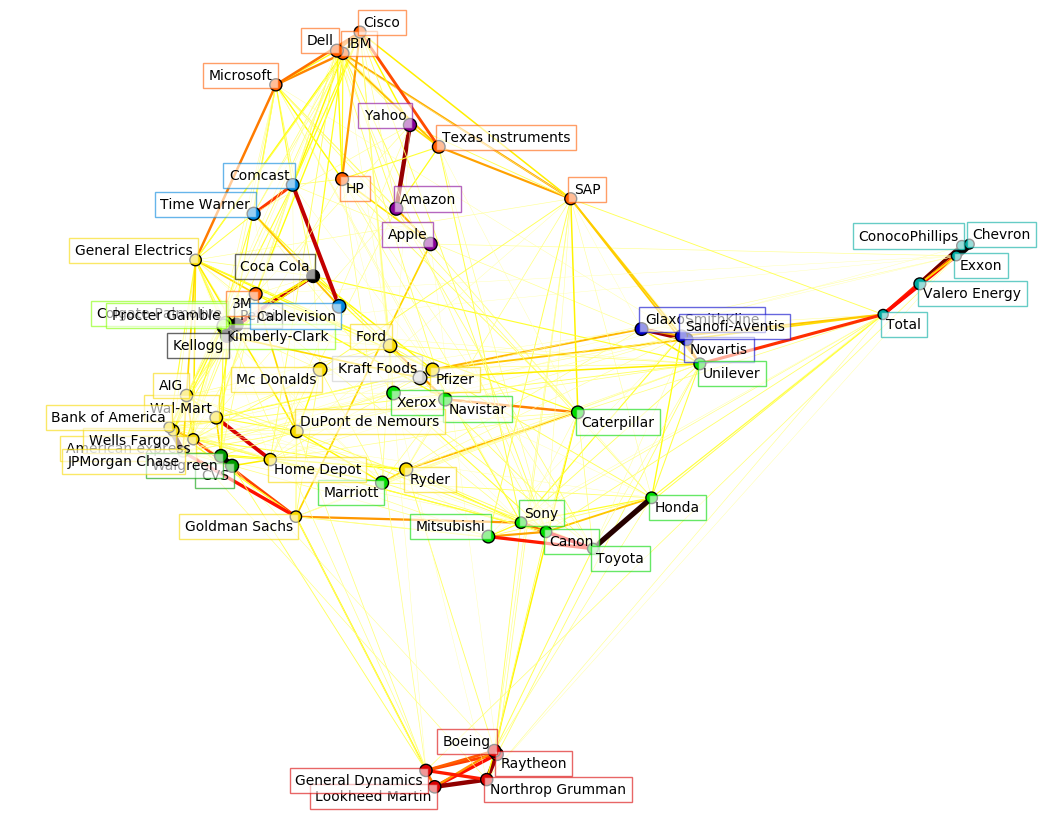

In [11]:
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

----------
## Linear Regression with 7 Features (id wise)

We are using 'open', 'close', 'high','low', 'volume', 'aclose', 'FutureOpen' to predict 'Rise' using Linear Regression.

In [19]:
DATA = TOT_df.ix[:,6:]
for i in range(1,1259):
    for j in range(6,14):
        DATA.ix[i,j] = float(DATA.ix[i,j])

In [20]:
DATA_train = DATA.ix[1:1000,:]

In [21]:
DATA_test = DATA.ix[1001:,:]

In [22]:
import numpy as np
from sklearn import linear_model

In [23]:
regr = linear_model.LinearRegression()

regr.fit(DATA_train.ix[:,6:12], DATA_train.ix[:,13])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([  1.85453371e-03,  -1.57360219e+00,  -2.47539289e-02,
         2.25297636e-02,   8.57157343e-09,  -1.57360219e+00,
         3.14171003e+00]))


In [25]:
mse = np.mean((regr.predict(DATA_test.ix[:,6:12]) - DATA_test.ix[:,13]) ** 2)
print("Mean squared error: %.2f" % mse)

Mean squared error: 0.32


## Linear Regression with 49 Features (id wise)

We are using the price of each stock in one week to predict the 'Rise' of next Monday.

In [19]:
DATA.shape

(1259, 8)